<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W3/ungraded_labs/C1_W3_Lab_1_improving_accuracy_using_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Improving Computer Vision Accuracy using Convolutions





# Shallow Neural Network

In the previous lessons, you saw how to do fashion recognition using a neural network containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and only one hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy. For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end. 

In [ ]:
import tensorflow as tf

# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

# Normalize the pixel values
training_images = training_images / 255.0
test_images = test_images / 255.0
#We add the .0 at the end of the number to guarantee a float64 division.

# Normalization

In the RGBA system, each pixel is represented by an intensity in one of the 3 channels: Red, Green, and Blue.

\- The intensities go from 0 to 255.

Dividing by 255 is equivalent to applying Min-Max normalization, or normalization through division by the maximum possible value:

I norm = (I - Imin)/(Imax - Imin) = (I - 0)/(255 - 0) = I/255

\- That is because the minimum possible value is zero. Then, the two methods (min-max normalization and division by the maximum possible value) get equivalent results.

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Setup training parameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5)

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)

## Convolutional Neural Network

In the model above, your accuracy will probably be about 89% on training and 87% on validation. Not bad. But how do you make that even better? One way is to use something called _convolutions_. We're not going into the details of convolutions in this notebook (please see resources in the classroom), but the ultimate concept is that **they narrow down the content of the image to focus on specific parts and this will likely improve the model accuracy**.

If you've ever done image processing using a **filter** (like [this](https://en.wikipedia.org/wiki/Kernel_(image_processing))), then convolutions will look very familiar. **In short, you take an array (usually 3x3 or 5x5) and scan it over the entire image.** By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 matrix that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision because **it often highlights features that distinguish one item from another.** Moreover, the amount of information needed is then much less because you'll just train on the highlighted features.

That's the concept of **Convolutional Neural Networks**. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focused and possibly more accurate.

Run the code below. This is the same neural network as earlier, but this time with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers added first. It will take longer, but look at the impact on the accuracy.

# Interpretation of the Sequential Model

## 1\. What is convolution?

Any kind of image processing usually involves having a filter and passing that filter over the image in order to **change the underlying image**. The convolution process works a little bit like this: 

\- For every pixel, take its value, and take a look at the value of its neighbors. 

\- If our filter is three by three, then we can take a look at the immediate neighbor, so that you have a corresponding three by three grid. 

\- Then, to get the new value for the pixel, we simply multiply each neighbor by the corresponding value in the filter, a**nd sum all these products**.

\- Repeat this for each neighbor and each corresponding filter value to have the new pixel **as the sum of each of the neighbor values multiplied by the corresponding filter value** - that is a convolution.  

> \- Obs: it is not possible to perform this operation for the edges, as we will see below, since these edges do not have the total amount of neighbors required. Therefore, we only apply the kernel filter (convolution) to the pixels that have the total of neighbors needed.

> \- If the Kernel is (3, 3), we need 3 x 3 matrices of pixels. Then, we only apply convolution to the pixels that are in the center of 3 x 3 matrices, i.e., pixels that are surrounded by other 8 pixels.
> 
> \- This is illustrated in the image below.

The idea here is that **some convolutions will change the image in such a way that certain features in the image get emphasized.** So, for example, you can have a filter (layer) which makes the vertical lines in the image really pop out. With another convolution, the horizontal lines pop out.

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
                                                         
  # Add convolutions and max pooling
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  #First argument of Conv2D: 32 = number of convolutions; use powers of 2: 32, 64, etc;
  #These powers usually start from 2^5 = 32.
  #Second argument of Conv2D: (3, 3): dimensions of the convolution filter. It takes a 3x3 matrix (pixel and 8 surrounding pixels)
  #The value of this central pixel after filtering will be the sum of the products between the intensity of a pixel and the number
  #on the correspondent position of the Kernel (position of the filter).
  #input_shape: dimensions of the images. (28, 28) is the dimension of the 28 x 28 pixels, input_shape[2] = 1 is color depth.
  #Since we are using gray scale, we need only a single byte, so this dimension is 1.
  
  tf.keras.layers.MaxPooling2D(2, 2),
  #Argument of MaxPooling2D: (2, 2) - the image is divided into several (2 x 2) pixels matrices. For each matrix, only the highest
  #(maximum) pixel intensity is selected (maximum value is kept, whereas the others are removed). After that, the selected values
  #are merged to form a new matrix. The length of the X axis of the new matrix is equal to the input X length divided by 2.
  #Also, the Y length is the input Y length divided by 2.

  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  # Add the same layers as before
  tf.keras.layers.Flatten(),
  #We do not have to define the input shape of the Flatten. It will be simply the input_shape of the images being fed.
  #Since the images passed through convolutions and pooling, each dimension was reduced in 2 units by each (3, 3) convolution 
  #(removal of the edges, where the pixels do not have 8 neighbors for the kernel filter to be applied); and were divided by 2 
  #by each of the (2, 2) MaxPoolings. If this division does not result in an integer, the dimension is rounded down to the 
  #lower integer that is closer to the division. e.g., if the division results in 5.5, the new dimension will be 5.

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Print the model summary
model.summary()

# Use same settings
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#'sparse_categorical_crossentropy' is a loss metric adequate for classification problems, not for regression ones.
#For regressions, we use 'mean_squared_error', for instance.

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5)

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)

Convolutional filter being applied to a boot image. The gray-scaled matrix represents the pixels of the highlighted region of the image, whereas the red region represents the convolutional filter. **Notice that \`NEW\_PIXEL\_VALUE\` represents only the new value of the central pixel (intensity 192)** \- the image does not illustrate the modificatios on the other 8 pixels shown.

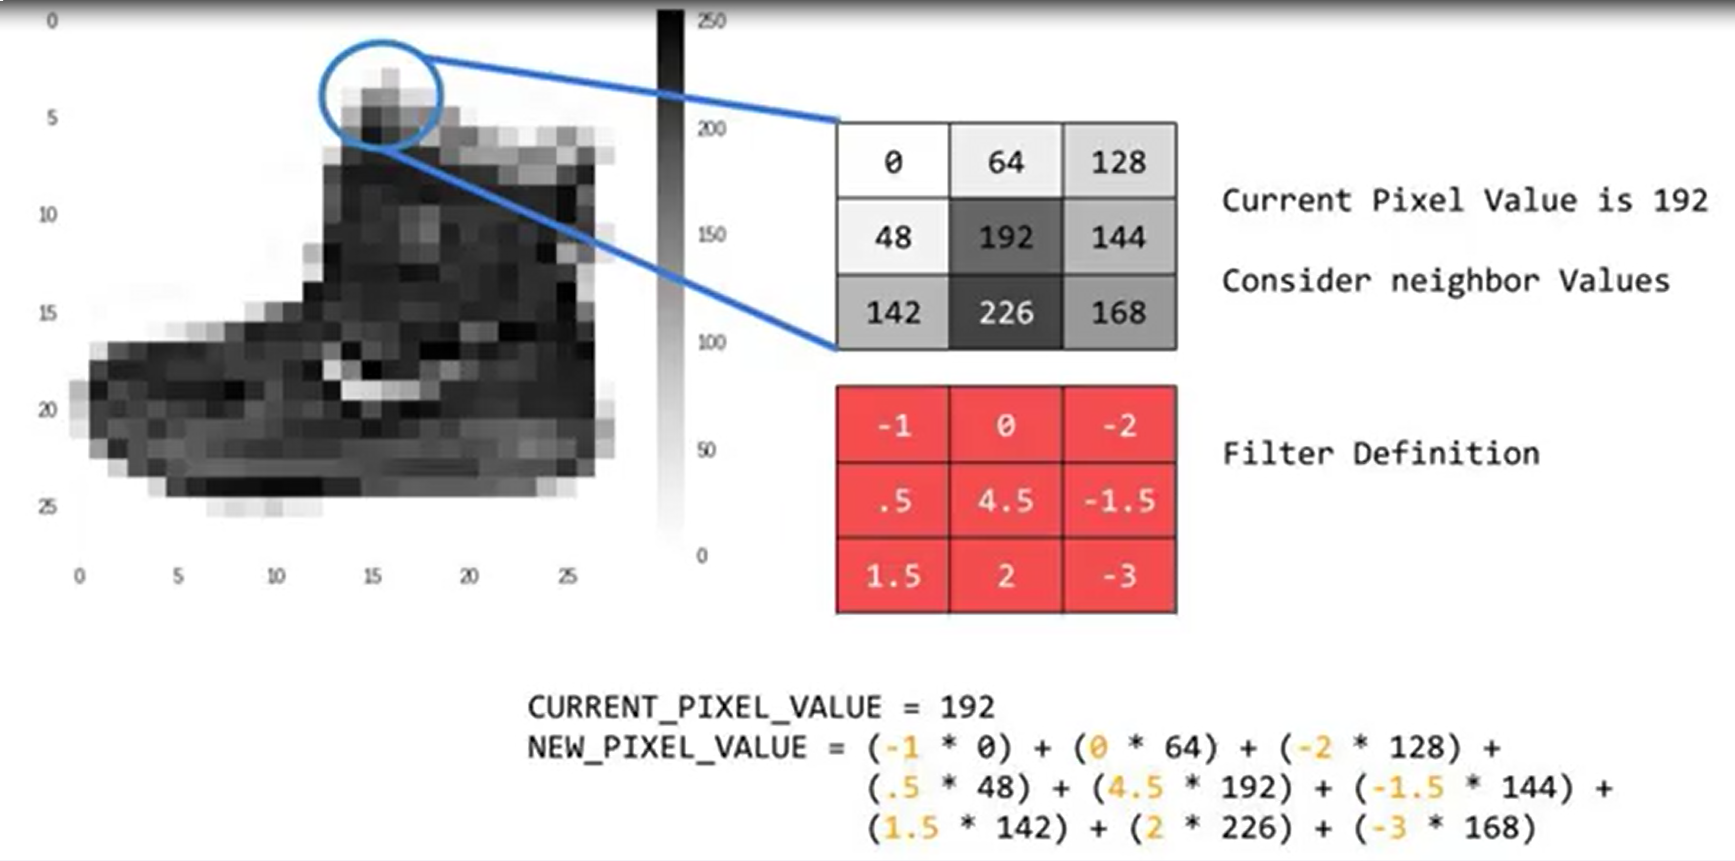

Convolution that emphasizes the vertical lines of the image, considered important basic features:

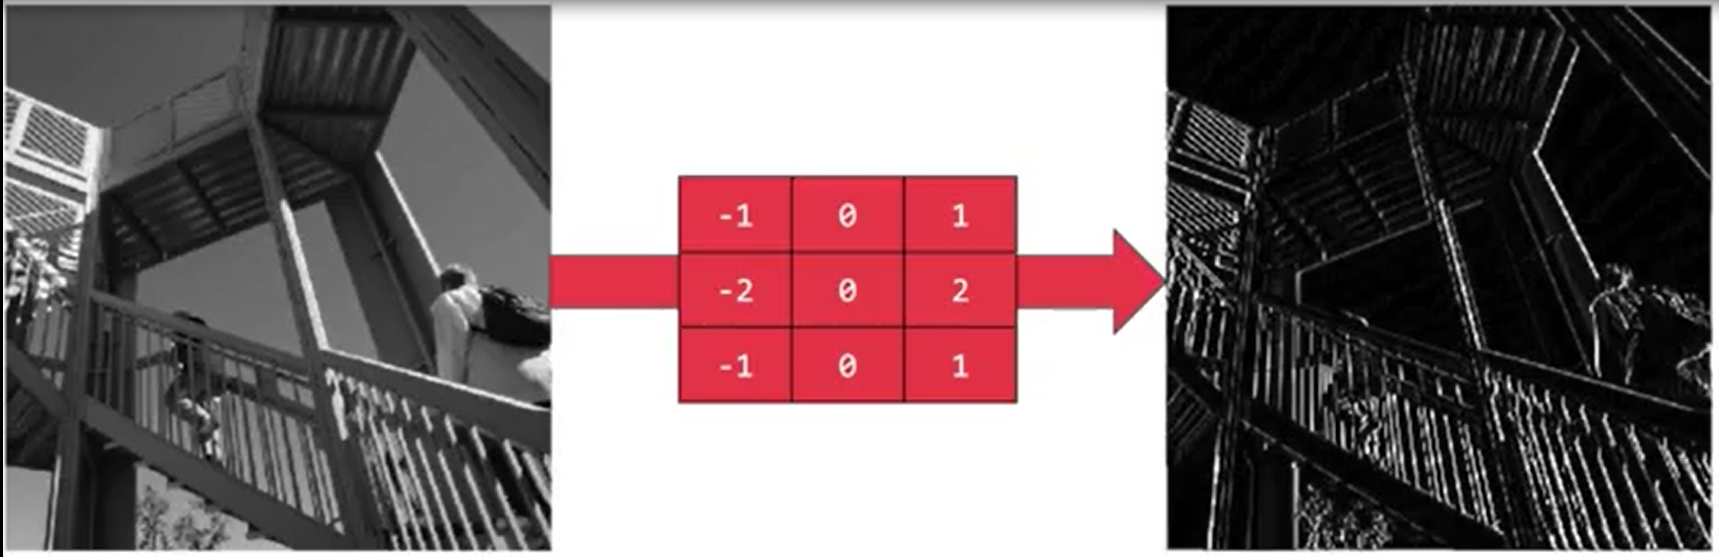

## 2\. Pooling

When combined with something called pooling, the convolutions can become really powerful. Simply, **pooling is a way of compressing an image**. 

\- A quick and easy way to do this is to go over the image of four pixels at a time, i.e, the current pixel and its neighbors underneath and to the right of it. **Of these four, pick only the biggest** **value and keep just that (this is the max pooling).** 

\- This **will preserve the features that were highlighted by the convolution**, while simultaneously quartering the size of the image (the size is divided by 2 x 2 = 4; wthe length of each axis is divided by 2).

\- This procedure is illustrated by one of the images below.

## 3\. Convolution and Pooling in code

We do not have to do all the math for filtering and compressing: we simply define convolutional and pooling layers to do the job for us. So, let's firstly analyze the code from the earlier example, with no convolution or pooling.

```
model = tf.keras.models.Sequential([

```

> ```
> tf.keras.layers.Flatten(),  
> 
> ```

> ```
> tf.keras.layers.Dense(128, activation=tf.nn.relu),
> 
> ```

> ```
> tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
> 
> ```

Here, we defined out a neural network to have: 

\- an input layer in the shape of our data; 

\- an output layer in the shape of the number of categories we are trying to define - 10 possible categories, so we use Dense(10); 

\- and a hidden layer in the middle. 

Remember: **the images from this dataset are 28 x 28 pixels**.

### The **Flatten takes our square 28 x 28 images and turns them into a one dimensional array**.

## 3.1. Add Convolution and Pooling

To add convolutions to this, we modify the code, as shown in the previous cell.

\- The last three lines are the same: the Flatten, the **Dense hidden layer with 128 neurons**, and the **Dense output layer with 10 neurons (number of neurons of the last dense layer must be equal to the number of possible classifications)**. 

```
tf.keras.layers.Flatten(),  

```
```
tf.keras.layers.Dense(128, activation='relu'),  

```
```
tf.keras.layers.Dense(10, activation='softmax')])

```

\- The difference is what has been added on top of this Sequential Model.

Let's take a look at this, line by line. 

### 3.1.1. First Convolution

```
model = tf.keras.models.Sequential([  

```

> ```
> tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape (28, 28, 1)), 
> 
> ```

Here we are specifying the first convolution. **We are asking keras to generate 32 filters for us (the first parameter)**. 

**\- These filters are 3 by 3, as specified by the hyperparameter (3,3)**. This means that the image will be divided into several 3 x 3 matrices (matrices of 9 pixels, i.e., a square containing 3 pixels in the horizontal and 3 pixels in the vertical). 

\- Their activation is **ReLU, which means the negative values will be thrown way** (ReLU: if the value X is lower than zero, then the output relu(X) = zero. If not, then the output is the value itself, i.e., relu(X) = X).

\- The input shape is again 28 by 28 - i.e., we have square images containing 28 pixels in the horizontal x 28 images in the vertical axis, totalizing 28 x 28 = 784 pixels. 

\- Notice that **Keras demands the images to have same constant dimensions**. This is the same that happens for sequences to be processed by Recurrent Neural Networks, where Keras demands the sequences to have same constant length.

\- It is expressed as the **hyperparameter input\_shape (28, 28, 1)**. That extra 1 just means that we are **using a single byte for color depth**. **That is because our image is on gray scale, so we just use one byte**. 

### What the 32 filters are?

They are not random. They **start with a set of known good filters** in a similar way to the pattern fitting, and **the ones that work for that set of images are learned** over time.

\- The common practice is to **use a number of convolutions given by a power of 2, starting from 32 = 2^5 = 32 convolutions, 2^6 = 64 convolutions, etc**.

### 3.1.2. First Pooling

This next line of code will then create a pooling layer. We apply a **max-pooling because we are going to take the maximum value**. 

```
tf.keras.layers.MaxPooling2D(2, 2),

```

Notice the **argument (2, 2)**: we say it is a a two-by-two pool,  since the pooling is applied to 2 x 2 matrices of pixels. So, **for every four pixels, the biggest one will survive and will be selected by this layer**. 

The diagram below represents a (2,2) max-pooling layer:

\- It divides the image into several (2 x 2) pixels matrices;

\- For each of these matrices, it selects **only the highest value of pixel intensity**;

\- Finally, it merge these selected values into a new matrix with lower dimensions.

**This procedure preserves the features that were highlighted by the convolution, while simulltaneously reducing the size of the image** (the original size is divided by 4 = 2 x 2).

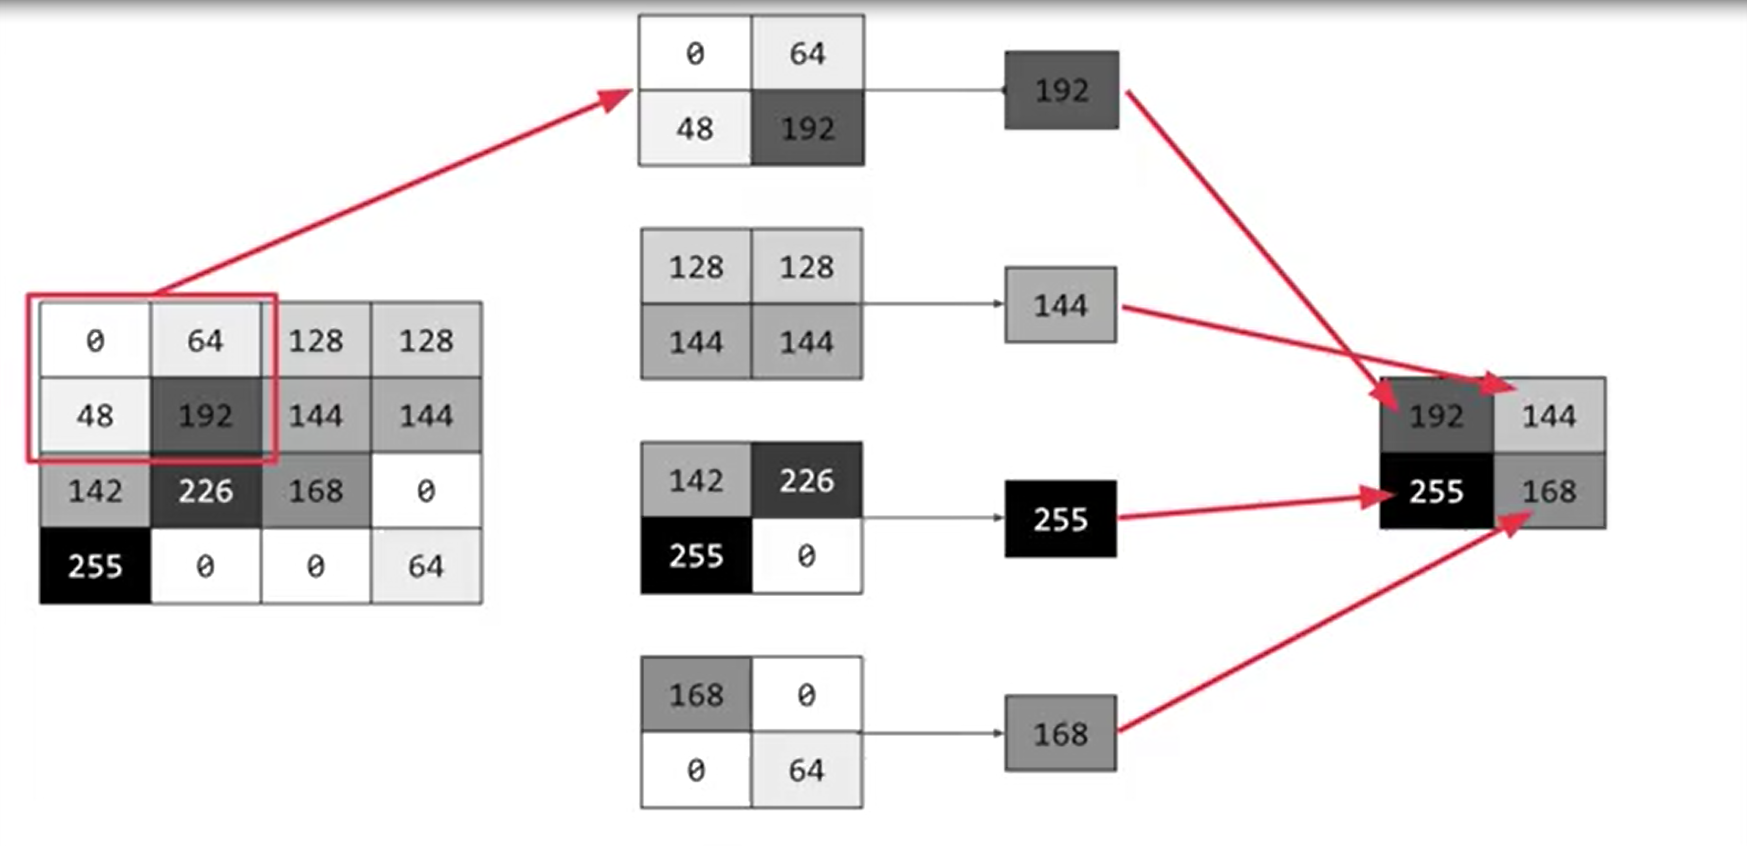

### 3.1.2. Next Convolution and Pooling

After the first pooling, we add another convolutional layer, and another max-pooling layer:

```
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

```
```
tf.keras.layers.MaxPooling2D(2,2),

```

With these new layers, the network can learn another set of convolutions on top of the existing one. Again, pool is applied to reduce the size. 

Due to these operations of convolution and pooling, by the time the image gets to the flatten to go into the dense layers, they are already much smaller. The images have been quartered, and then quartered again (each (2, 2) pooling results in an image with 1/4 of the size of the image being input into that layer).

Therefore, at the end of the neural network, the images' content have been greatly simplified. **The goal with these convolution and pooling simplification steps is to filter or highlight in the images their features that actually determine the model output.** 

**In other words, these steps emphasize those features that really determine which classification the model should provide to that particular image.**

\- e.g. what makes that object to be characterized as a shirt, instead of a boot; which elements of the images are characteristic from boots, etc. Naturally, it depends on the labels/classifications that should be given. In some cases, it can be seen as highlighting the contour or edges; or highlighting the vertical or horizontal lines, as in the previous illustrated example.

## 3.2. model.summary method

A really useful method that can be applied to the Sequential Model is the model.summary method. This allows you to **inspect the layers of the model, and to see the journey of the image throughout the convolutions, from the first Convolution layer to the output**. 

```
model.summary()

```

The output of this method is a table showing us the layers, and some details about them, including the output shape. It is important to keep an eye on the output shape column. When you first look at this, it can be a little bit confusing:

\- The data is constituted by 28 by 28 images; 

1\. The output of the neural network is 26 by 26. 

\- The key to this is remembering that the filter is a (3 x 3). Consider what happens when you start scanning through an image starting on the top left (first or more superior line of pixels of the image). **You cannot calculate the filter for the pixel in the top left, because it does not have any neighbors above it or on its left**. In a similar fashion, the next pixel on the right (of the first top one) will not work either, because it also does not have any neighbors above it. 

\- So, logically, the first pixel that you can do calculations on is the second pixel (from left to right) of the second line of pixels (from top to bottom), **because this one of course has all eight neighbors required by a (3 x 3) filter to be applied**.

\- This  means that **you cannot use a one pixel margin all around the image**.

Therefore, **the output of the convolution will be 2 pixels smaller on X and 2 pixels smaller on Y for a 3 x 3 filter**. If your filter is 5 x 5, for similar reasons your output will be 4 pixels smaller on X, and 4 pixels smaller on Y. 

### In summary, **when applying a (N, N) filter for convolution, the output of the convolution layer will be (N - 1) pixels smaller on axis X; and (N - 1) pixels smaller on axis Y when compared to the image that was used as input for that layer**.

\- So, that is why the application of a (3, 3) filter on a 28 x 28 pixels image results in an output with 26 x 26 pixels after convolution. We removed that one pixel on X and Y for each of the 4 borders.

The next image shows the first pixel to which the (3, 3) filter can be applied: **it is the first pixel that is in the central position of a 3 x 3 matrix of pixels, i.e., the first one containing 8 neighbors** (as previously discussed).

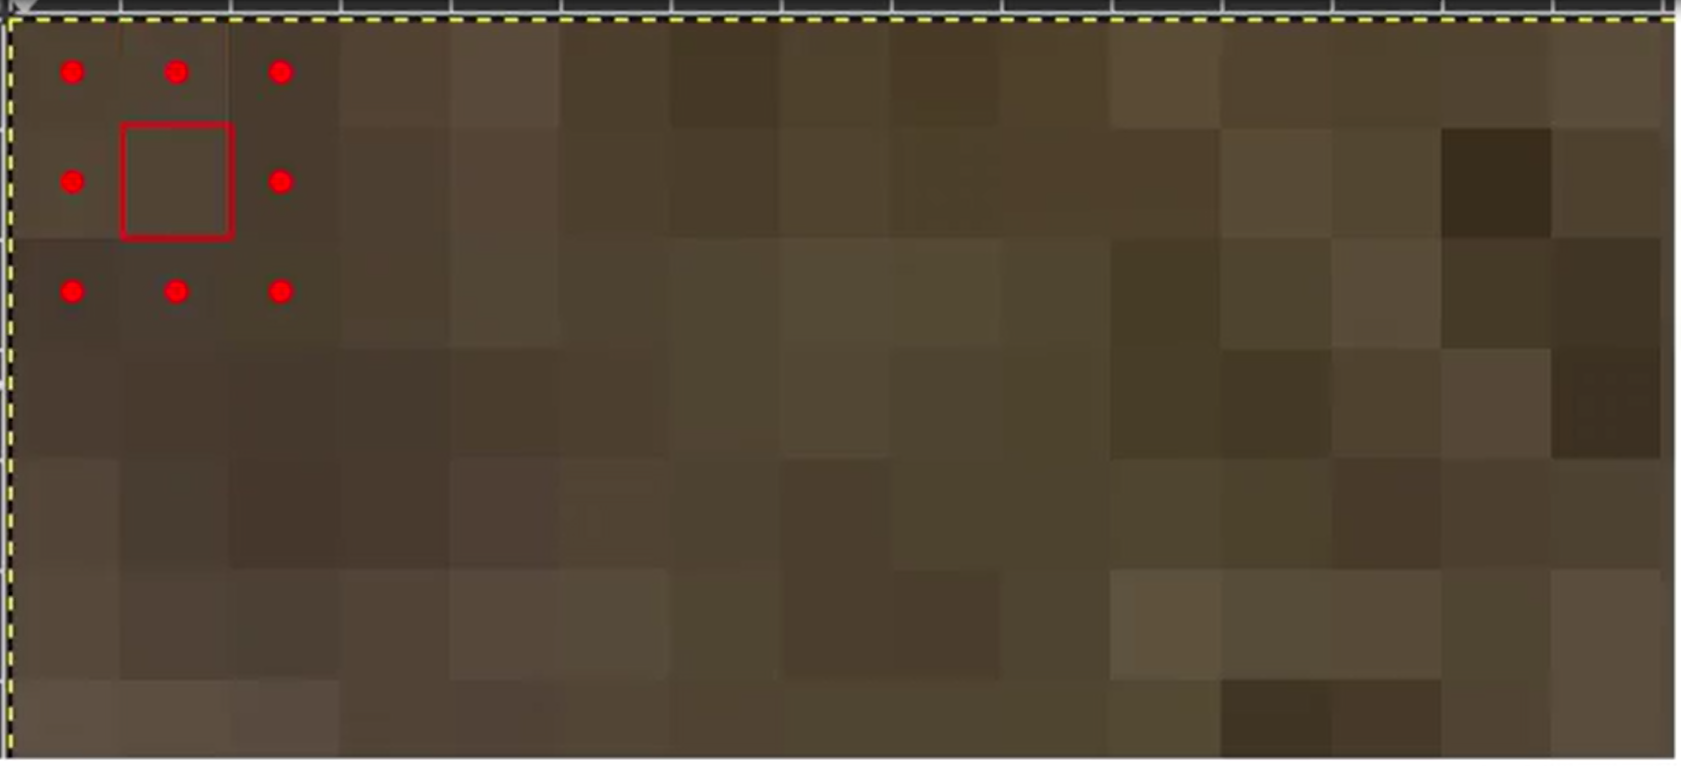

2\. Nextly, the model.summary method shows the first of the max-pooling layers. Since we specified it to be **2 x 2, this layer turns 4 pixels into 1, and so the length of each axis is divided by 2**. 

\- Then, our output gets reduced from 26 x 26 pixels to 13 x 13. 

3\. The second convolution will then operate on that. Again, we lose the 1 pixel margin as before due to the (3, 3) filter, so the length of each axis is again reduced in 2 pixels. Now, the output shape is 11 x 11 pixels. 

4\. Due to the second (2, 2) max-pooling, the image is again reduced. **Notice that the division of 11 / 2 = 5.5 does not result into an integer. Then, the dimension of the output is rounded down to the integer value immediately inferior to 5.5, resulting in 5 x 5 images.** 

5\. Our dense neural network is the same as before, but it is **being fed with 5 x 5 pixels images instead of the 28 x 28 pixels original ones**.

\- Importantly, it is not just one compressed to 5 x 5 image being used instead of the original 28 x 28 one: **there are a number of convolutions per image that we specified, in this case 32. So, there are 32 new images of 5 x 5 pixels that had been fed into the neural networks**. 

6\. Flatten that out and you **have (5 x 5) = 25 pixels times 32, which results in 800 values**.

\- So, you can see that the new flattened layer has 800 elements in it, as opposed to the 784 that you had previously. This number is impacted by the parameters that you set when defining the convolutional 2D layers. 

\- When you are feeding less than 784 over all pixels in, training should be faster.

The next image shows the dimensions obtained when applying 64 convolutions, as would be obtained )with the following line of code:

```
tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape (28, 28, 1)), 

```

In this case, **flatten would result in 25 pixels x 64 = 1600 elements** (shown in Layer: flatten\_5 (Flatten) of the table on the next figure). 

Since there are many more images to train the neural networks, training would be much slower when compared to the case where no convolution is applied (situation where only the original \`784 elements = 28 x 28 = total of pixels from the images\` are fed into the neural networks).

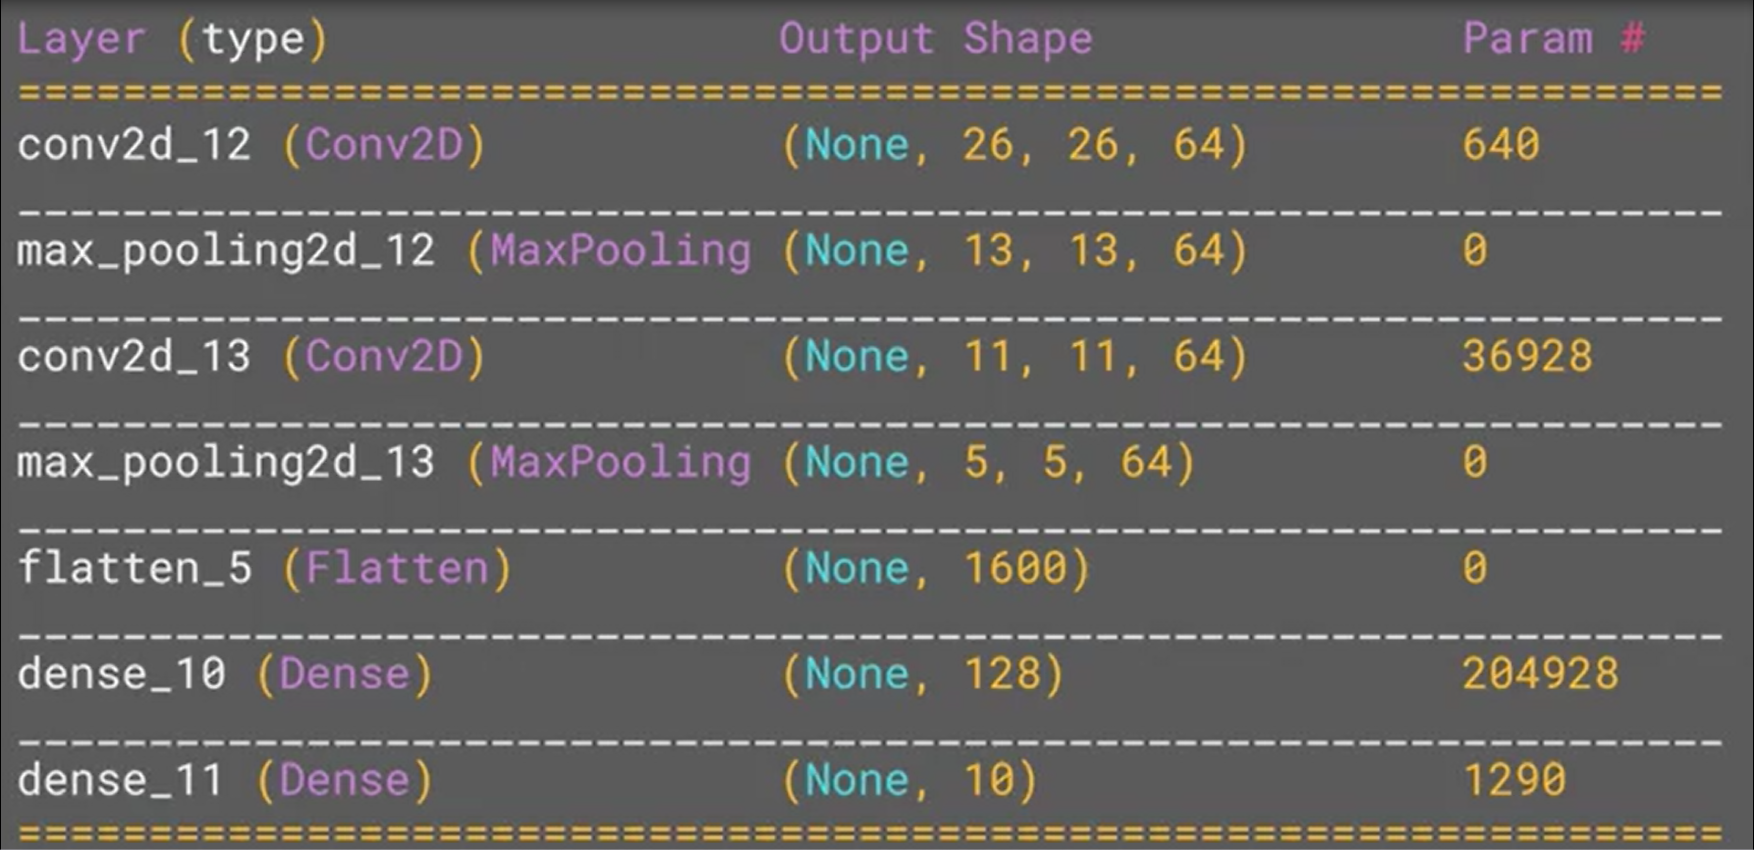

# How Tensorflow works when training CNNs

\- A (3, 3) 2D-convolution (32) filter each image using 32 different possible filters, resulting in **32 convolutions for each image. The idea is that each convolution will highlight one of the most important features of the image.** If an image does not show the main features that determine a given classification, it is not likely to be labeled as belonging to that category.

\- **A convolution image filter is simply a matrix of numbers**: each pixel of the image will be multiplied by the correspondent element of the filter, according to its position on the convolution matrix: element (i, j) of the matrix of pixels will have its **intensity** multiplied by the (i,j) element of the filter. This was shown in an image above. **The new value of the pixel in the center of the matrix (i.e, the pixel that is receiving the filter) will be the sum of these products.**

The goal here is to **find the best combination of (3 x 3) = 9 numbers that, when applied to each pixel of the images that can be filtered** (i.e, the pixels surrounded by other 8 pixels, as discussed)**, will result in the extraction of one of the most important features for determining the image label**. Obviously, there is an infinite number of possible combinations of 9 numbers.

## Under the hood, Tensorflow is trying different filters on your images and learning which ones work when looking at the training data.

\- As a result, when it works (when Tensorflow finds the best combination), you will have greatly reduced the information that must be passed through the network. 

\- **Since the convolutions and poolings isolate and identifie features, you can also get increased accuracy**.

# Code output discussion

It's likely gone up to about 92% on the training data and 90% on the validation data. That's significant, and a step in the right direction!

Look at the code again, and see, step by step how the convolutions were built. Instead of the input layer at the top, you added a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). The parameters are:

1. The number of convolutions you want to generate. **The value here is purely arbitrary but it's good to use powers of 2 starting from 32**.
2. The size of the Convolution. In this case, a 3x3 grid.
3. The activation function to use. In this case, you used a ReLU, which you might recall is the equivalent of returning `x` when `x>0`, else return `0`.
4. In the first layer, the shape of the input data.

You'll follow the convolution with a **[MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer which is designed to compress the image, while maintaining the content of the features that were highlighted by the convolution.** By specifying `(2,2)` for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that **it creates a 2x2 array of pixels, and picks the biggest one.** Thus, it turns 4 pixels into 1. It repeats this across the image, and in doing so, it halves both the number of horizontal and vertical pixels, effectively reducing the image to 25% of the original image.

You can call `model.summary()` to see the size and shape of the network, and you'll notice that after every max pooling layer, the image size is reduced in this way.

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

```

Then you added another convolution and flattened the output.



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
  tf.keras.layers.Flatten(),
  
```


After this, you'll just have the same DNN structure as the non convolutional version. The same 128 dense layers, and 10 output layers as in the pre-convolution example:



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```


## About overfitting

Try running the training for more epochs -- say about 20, and explore the results. But while the results might seem really good, the validation results may actually go down, due to something called _overfitting_. In a nutshell, overfitting occurs when the network learns the data from the training set really well, **but it's too specialised to only that data,** and **as a result is less effective at interpreting other unseen data.** For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it. But blue suede shoes might confuse you... and you know you should never mess with my blue suede shoes.

# Visualizing the Convolutions and Pooling

Let's explore how to show the convolutions graphically. The cell below prints the first 100 labels in the test set, and you can see that the ones at index `0`, index `23` and index `28` are all the same value (i.e. `9`). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the dense layer is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [ ]:
print(test_labels[:100])

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

f, axarr = plt.subplots(3,4)

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

### EXERCISES

1. Try editing the convolutions. Change the 32s to either 16 or 64. What impact will this have on accuracy and/or training time.

2. Remove the final Convolution. What impact will this have on accuracy or training time?

3. How about adding more Convolutions? What impact do you think this will have? Experiment with it.

4. Remove all Convolutions but the first. What impact do you think this will have? Experiment with it. 

5. In the previous lesson you implemented a callback to check on the loss function and to cancel training once it hit a certain amount. See if you can implement that here.